In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('reharmonization_runs.json', orient='records')

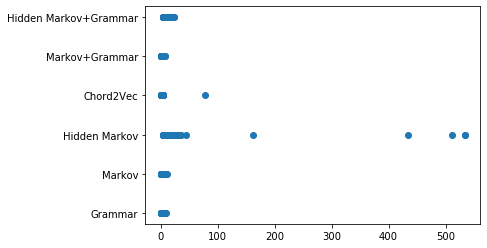

In [3]:
plt.scatter(y='method', x='time', data=df)

In [4]:
results = pd.DataFrame(
    index=['Grammar', 'Chord2Vec', 'Markov', 'Markov+Grammar', 'Hidden Markov', 'Hidden Markov+Grammar']
)

In [44]:
roots = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
def make_chordname(frame):
    frame['chordname'] = frame['base'].apply(roots.__getitem__).str.cat(frame['mode'])
    return frame

In [45]:
def expand_row(row):
    originals    = make_chordname(pd.DataFrame(row.original)).rename(columns=lambda x: 'or_'+x)
    reharmonized = make_chordname(pd.DataFrame(row.reharmonized)).rename(columns=lambda x: 're_'+x)
    rowframe = pd.concat([originals, reharmonized], axis=1)
    rowframe['method'] = row.method
    rowframe['song'] = row.song
    return rowframe

gr = pd.concat(list(df.apply(expand_row, axis=1)), axis=0)

In [52]:
results['Average Changed'] = gr.groupby('method').re_reharmonized.mean()
results['Changed at all']  = gr.groupby(['method', 'song', 'or_start']) \
                                .re_reharmonized.any().groupby('method').mean()
results['Average Alternatives']  = gr.groupby(['method', 'song', 'or_start']).re_chordname.nunique() \
                                     .groupby('method').mean() - 1

results

,Average Changed,Changed at all,weak,strong,jazz,unacceptable,Average Alternatives
Grammar,0.44,0.87,0.18,0.27,0.40,0.15,1.21
Chord2Vec,0.39,0.87,0.23,0.30,0.37,0.10,1.13
Markov,0.73,0.99,0.24,0.21,0.35,0.19,11.34
Markov+Grammar,0.20,0.61,0.26,0.33,0.30,0.11,0.65
Hidden Markov,0.64,0.97,0.39,0.23,0.31,0.07,6.68
Hidden Markov+Grammar,0.18,0.44,0.32,0.34,0.27,0.06,0.45


# Chord - Melody Interplay

Harmony classification according to this table:
![](http://www.thejazzpianosite.com/wp-content/uploads/2016/12/How-to-Reharmonize-a-Song.png)

In [19]:
W = 'weak'; S = 'strong'; J = 'jazz'; U = 'unacceptable'

harmony_type = {
    #        C,Db, D,Eb, E, F,Gb, G,Ab, A,Bb, B
    '':     [W, U, J, U, S, U, J, W, U, J, U, S],
    'maj7': [W, U, J, U, S, U, J, W, U, J, U, S],
    '7':    [W, J, J, J, S, U, J, W, J, J, S, U],
    'm':    [W, U, J, S, U, J, U, W, U, J, S, U],
    'm7':   [W, U, J, S, U, J, U, W, U, J, S, U],
    'ø':    [W, U, J, S, U, J, S, U, J, U, S, U],
    'o':    [W, U, J, S, U, J, S, U, J, S, U, J],
    'o7':   [W, U, J, S, U, J, S, U, J, S, U, J],
    '+':    [W, J, J, J, S, U, J, U, S, J, S, U],
}

In [20]:
from itertools import product

def extract_pairings(row):
    reharmonized = row.reharmonized
    melody = row.melody
    
    pairings = []
    for r, m in product(reharmonized, melody):
        if(r['start']+r['duration'] > m['start'] and m['start']+m['duration'] > r['start']):
            newpair = {'method': row.method, 'song': row.song}
            for k in r:
                newpair['chord_'+k] = r[k]
            for k in m:
                newpair['mel_'+k] = m[k]
            pairings.append(newpair)
    return pairings
    
pairings = pd.DataFrame(list(np.concatenate(df.apply(extract_pairings, axis=1))))

In [21]:
def get_harmony_type(row):
    harmonies = harmony_type[row.chord_mode]
    return harmonies[(row.mel_note - row.chord_base + 12) % 12]

pairings['harmony_type'] = pairings.apply(get_harmony_type, axis=1)

In [14]:
types_per_method = pairings[pairings.chord_reharmonized].groupby('method').harmony_type.value_counts(normalize=True)

for t in [W, S, J, U]:
    results[t] = types_per_method[:, t]

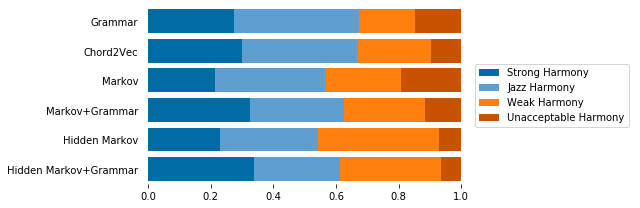

In [15]:
fig = plt.figure(figsize=(9, 3), )
ax = plt.axes(frameon=False)
plt.style.use('tableau-colorblind10')

plt.barh(results.index, results['strong'], color='C0', label='Strong Harmony'); cum = results['strong'].copy()
plt.barh(results.index, results['jazz'], color='C4', left=cum, label='Jazz Harmony'); cum += results['jazz']
plt.barh(results.index, results['weak'], color='C1', left=cum, label='Weak Harmony'); cum += results['weak']
plt.barh(results.index, results['unacceptable'], color='C5', left=cum, label='Unacceptable Harmony')

plt.ylim([5.5, -.5])
plt.xlim([-.02, 1.55])
plt.xticks(np.arange(0, 1.1, 0.2))
ax.tick_params(axis='y', which=u'both',length=0)

plt.legend(loc='right')
plt.tight_layout()
plt.savefig('/home/konrad/thesis/tex/figures/analysis/reharmonization-harmony.pdf')